# Embedding Models

Resource: https://www.deeplearning.ai/short-courses/embedding-models-from-architecture-to-implementation/

In [1]:
import warnings

warnings.filterwarnings('ignore')

## Contextual token embeddings

### Glove word embeddings

In [2]:
import gensim.downloader as api

word_vectors = api.load("glove-wiki-gigaword-100")

In [3]:
word_vectors["king"].shape

(100,)

In [4]:
word_vectors["king"][:20]

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 ], dtype=float32)

In [5]:
import numpy as np

# Words to visualize
words = ["king", "princess", "monarch", "throne", "crown", "mountain", "ocean", "tv", "rainbow", "cloud", "queen"]

# Get word vectors
vectors = np.array([word_vectors[word] for word in words])

In [6]:
from sklearn.decomposition import PCA

# Reduce dimensions
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)

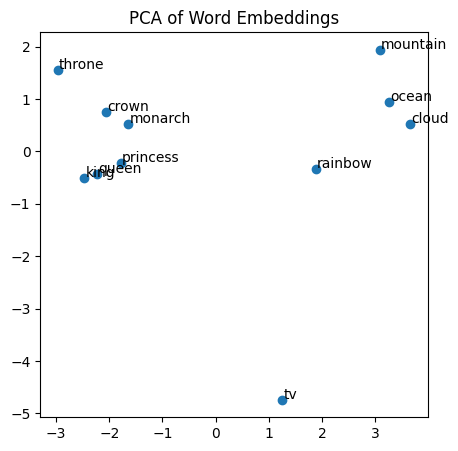

In [7]:
import matplotlib.pyplot as plt

# Plot word embeddings
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(vectors_pca[:, 0], vectors_pca[:, 1])
for i, word in enumerate(words):
    axes.annotate(word, (vectors_pca[i, 0] + 0.02, vectors_pca[i, 1] + 0.02))
axes.set_title("PCA of Word Embeddings")
plt.show()

### Word2Vec algebra

In [8]:
# Compare vectors and word embeddings operation
result = word_vectors.most_similar(
    positive=["king", "woman"],
    negative=["man"],
    topn=1
)

print(f"The word closest to 'king' - 'man' + 'woman' is: '{result[0][0]}' with a similarity score of {result[0][1]}""")

The word closest to 'king' - 'man' + 'woman' is: 'queen' with a similarity score of 0.7698540687561035


### Compare GloVe and BERT

In [9]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertModel.from_pretrained("google-bert/bert-base-uncased")  

In [10]:
# Get embeddings
def get_bert_embeddings(sentence, word):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs)
    
    last_hidden_state = outputs.last_hidden_state
    
    word_tokens = tokenizer.tokenize(sentence)
    word_index = word_tokens.index(word)
    word_embedding = last_hidden_state[0, word_index + 1, :]
    
    return word_embedding

In [11]:
sentence_1 = "The bat flew out of the cave at night."
sentence_2 = "He swung the bat and hit a home run."

word = "bat"

bert_embedding_1 = get_bert_embeddings(sentence_1, word)
bert_embedding_2 = get_bert_embeddings(sentence_2, word)
word_embedding = word_vectors[word]

In [12]:
print(f"BERT embedding for 'bat' in sentence 1: {bert_embedding_1[:5]}")
print(f"BERT embedding for 'bat' in sentence 2: {bert_embedding_2[:5]}")

BERT embedding for 'bat' in sentence 1: tensor([ 0.4132, -0.1291, -0.4487, -0.4049, -0.1531], grad_fn=<SliceBackward0>)
BERT embedding for 'bat' in sentence 2: tensor([ 0.6407, -0.3112, -0.4409, -0.1655, -0.2006], grad_fn=<SliceBackward0>)


In [13]:
from sklearn.metrics.pairwise import cosine_similarity

bert_similarity = cosine_similarity(
    [bert_embedding_1.detach().numpy()], 
    [bert_embedding_2.detach().numpy()]
)[0][0]

glove_similarity = cosine_similarity(
    [word_embedding],
    [word_embedding]
)[0][0]

print(f"Cosine similarity between BERT embeddings in different contextes: {bert_similarity}")
print(f"Cosine similarity between GloVe embeddings: {glove_similarity}")

Cosine similarity between BERT embeddings in different contextes: 0.45995745062828064
Cosine similarity between GloVe embeddings: 1.0


### Check cross encoder

In [15]:
from sentence_transformers import CrossEncoder
import torch

model = CrossEncoder(
    model_name_or_path="cross-encoder/ms-marco-MiniLM-L-6-v2", 
    max_length=512, 
    activation_fn=torch.nn.Sigmoid()
)

In [16]:
question = "Where ist the capital of Germany"
answers = [
    "Paris is the capital of France.",
    "Berlin is the capital of Germany.",
    "Madrid is the capital of Spain."
]

In [17]:
scores = model.predict(
    [
        (question, answers[0]),
        (question, answers[1]),
        (question, answers[2])
    ]
)
print(scores)

[6.8226393e-04 9.9092346e-01 3.4640532e-04]


In [18]:
most_relevant_idx = torch.argmax(torch.tensor(scores)).item()
print(f"The most relevant answer is: '{answers[most_relevant_idx]}'")

The most relevant answer is: 'Berlin is the capital of Germany.'


## Compare token and sentence embeddings

### Get sentence embeddings

In [20]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

from transformers import BertModel, BertTokenizer
from datasets import load_dataset

In [21]:
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertModel.from_pretrained("google-bert/bert-base-uncased")

In [22]:
def get_sentence_embedding(sentence):
    encoded_input = tokenizer(sentence, padding=True, return_tensors="pt")
    attention_mask = encoded_input["attention_mask"]
    
    with torch.inference_mode():
        output = model(**encoded_input)
        
    token_embeddings = output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(dim=-1).expand(token_embeddings.size()).float()
    
    sentence_embedding = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    return sentence_embedding.flatten().tolist()

In [23]:
def cosine_similarity_matrix(featuers):
    norms = np.linalg.norm(
        featuers,
        axis=1,
        keepdims=True,
    )
    normalized_featuers = featuers / norms
    
    similarity_matrix = np.inner(normalized_featuers, normalized_featuers)    
    rounded_similarity_matrix = np.round(similarity_matrix, 4)
    
    return rounded_similarity_matrix

In [24]:
import seaborn as sns

def plot_similarity(labels, features, rotation):
    sim = cosine_similarity_matrix(features)
    sns.set_theme(font_scale=1.2)
    g = sns.heatmap(
        sim, 
        xticklabels=labels, 
        yticklabels=labels, 
        vmin=0, 
        vmax=1, 
        cmap="YlOrRd"
    )
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    return g

### Token embeddings

In [25]:
messages = [
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    "How old are you?",
    "what is your age?",
]

<Axes: title={'center': 'Semantic Textual Similarity'}>

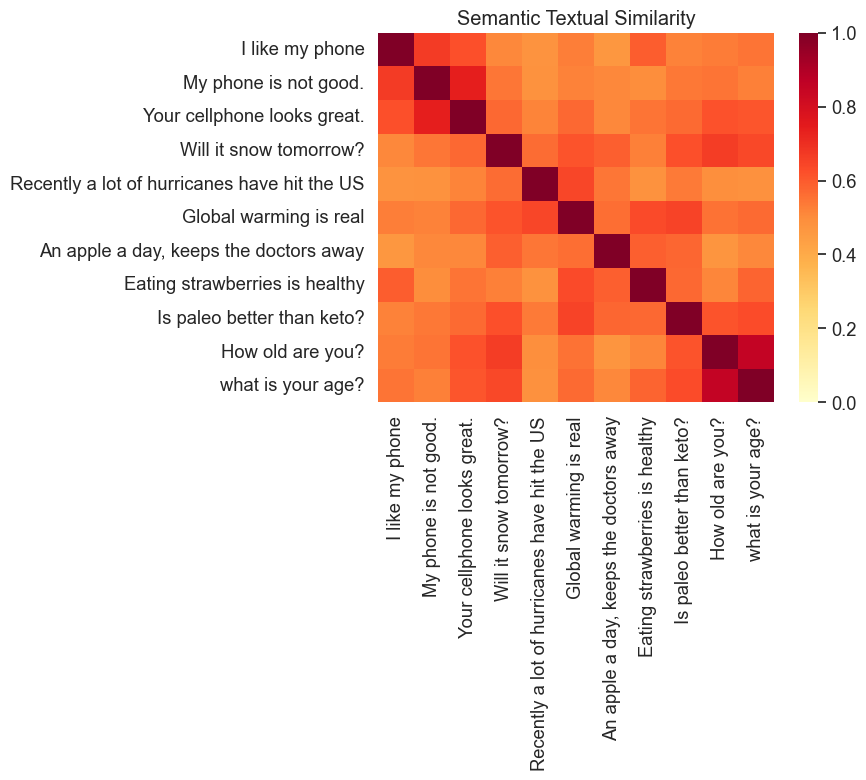

In [26]:
embeddings = [
    get_sentence_embedding(t) for t in messages
]

plot_similarity(messages, embeddings, 90)

In [27]:
from datasets import load_dataset
import pandas as pd

sts_dataset = load_dataset("mteb/stsbenchmark-sts")
sts = pd.DataFrame({
    'sentence_1': sts_dataset['test']['sentence1'], 
    'sentence_2': sts_dataset['test']['sentence2'],
    'score': [x/5 for x in sts_dataset['test']['score']]
})
sts.head(10)

Generating test split: 100%|██████████| 1379/1379 [00:00<00:00, 62537.25 examples/s]


,sentence_1,sentence_2,score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400
4,A man is playing a harp.,A man is playing a keyboard.,0.3000
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000
7,A man is playing the drums.,A man is playing the guitar.,0.4400
8,A man is playing guitar.,A lady is playing the guitar.,0.4400
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428


In [28]:
def sim_two_sentences(s1, s2):
    emb1 = get_sentence_embedding(s1)
    emb2 = get_sentence_embedding(s2)
    sim = cosine_similarity_matrix(
        np.vstack([emb1, emb2])
    )
    return sim[0, 1]

In [29]:
n_examples = 50
sts = sts.head(n_examples)

In [30]:
sts["avg_bert_score"] = np.vectorize(sim_two_sentences) (sts["sentence_1"], sts["sentence_2"])
sts.head(10)

,sentence_1,sentence_2,score,avg_bert_score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000,0.9767
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200,0.9615
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000,0.9191
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400,0.9763
4,A man is playing a harp.,A man is playing a keyboard.,0.3000,0.9472
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600,0.8787
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000,0.9793
7,A man is playing the drums.,A man is playing the guitar.,0.4400,0.9730
8,A man is playing guitar.,A lady is playing the guitar.,0.4400,0.9519
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428,0.9588


### SBERT and dual encoder

<Axes: title={'center': 'Semantic Textual Similarity'}>

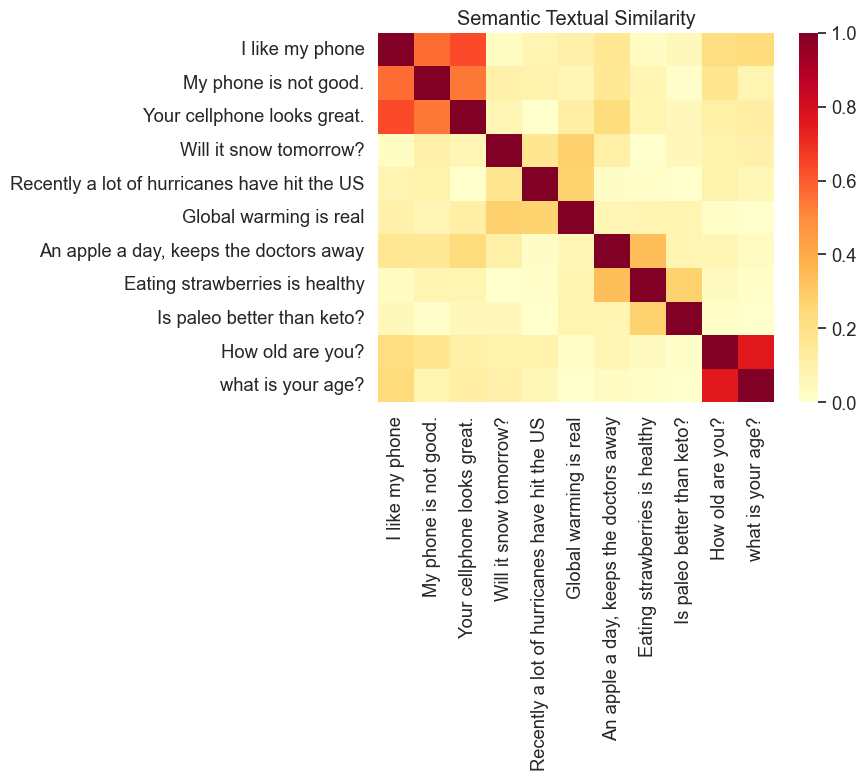

In [31]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

embeddings = [
    list(model.encode(t)) for t in messages
]

plot_similarity(messages, embeddings, 90)

In [32]:
def sim_two_sentences(s1, s2):
    emb1 = list(model.encode(s1))
    emb2 = list(model.encode(s2))
    sim = cosine_similarity_matrix(np.vstack([emb1, emb2]))
    return sim[0,1]

In [33]:
sts['mini_LM_score'] = np.vectorize(sim_two_sentences)(sts['sentence_1'], sts['sentence_2'])
sts.head(10)

,sentence_1,sentence_2,score,avg_bert_score,mini_LM_score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000,0.9767,0.8052
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200,0.9615,0.7886
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000,0.9191,0.9465
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400,0.9763,0.8820
4,A man is playing a harp.,A man is playing a keyboard.,0.3000,0.9472,0.3556
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600,0.8787,0.5017
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000,0.9793,0.8074
7,A man is playing the drums.,A man is playing the guitar.,0.4400,0.9730,0.4757
8,A man is playing guitar.,A lady is playing the guitar.,0.4400,0.9519,0.6182
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428,0.9588,0.5096


In [34]:
import scipy

pc = scipy.stats.pearsonr(sts['score'], sts['mini_LM_score'])
print(f'Pearson correlation coefficient = {pc[0]}\np-value = {pc[1]}')

Pearson correlation coefficient = 0.9303740673726043
p-value = 1.4823857251915091e-22


## Training and dual encoder

### CrossEntropyLoss 'trick'

In [35]:
df = pd.DataFrame(
    [
        [4.3, 1.2, 0.05, 1.07],
        [0.18, 3.2, 0.09, 0.05],
        [0.85, 0.27, 2.2, 1.03],
        [0.23, 0.57, 0.12, 5.1]
    ]
)
data = torch.tensor(df.values, dtype=torch.float32)

In [36]:
def contrastive_loss(data):
    target = torch.arange(data.size(0))
    loss = torch.nn.CrossEntropyLoss()(data, target)
    return loss

In [37]:
torch.nn.Softmax(dim=1)(data)

tensor([[0.9100, 0.0410, 0.0130, 0.0360],
        [0.0429, 0.8801, 0.0393, 0.0377],
        [0.1512, 0.0846, 0.5832, 0.1810],
        [0.0075, 0.0105, 0.0067, 0.9753]])

In [38]:
torch.nn.Softmax(dim=1)(data).sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000])

In [39]:
N = data.size(0)
non_diag_mask = ~torch.eye(N, N, dtype=bool)

In [40]:
for inx in range(3):
    data = torch.tensor(df.values, dtype=torch.float32)
    data[range(N), range(N)] += inx*0.5
    data[non_diag_mask] -= inx*0.02
    print(data)
    print(f"Loss: {contrastive_loss(data)}")

tensor([[4.3000, 1.2000, 0.0500, 1.0700],
        [0.1800, 3.2000, 0.0900, 0.0500],
        [0.8500, 0.2700, 2.2000, 1.0300],
        [0.2300, 0.5700, 0.1200, 5.1000]])
Loss: 0.19657586514949799
tensor([[4.8000, 1.1800, 0.0300, 1.0500],
        [0.1600, 3.7000, 0.0700, 0.0300],
        [0.8300, 0.2500, 2.7000, 1.0100],
        [0.2100, 0.5500, 0.1000, 5.6000]])
Loss: 0.12602083384990692
tensor([[5.3000, 1.1600, 0.0100, 1.0300],
        [0.1400, 4.2000, 0.0500, 0.0100],
        [0.8100, 0.2300, 3.2000, 0.9900],
        [0.1900, 0.5300, 0.0800, 6.1000]])
Loss: 0.07888662070035934


### Create encoder

In [41]:
class Encoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim) -> None:
        super().__init__()
        
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=3,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False,
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)
        
    def forward(self, tokenizer_output):
        x = self.embedding_layer(tokenizer_output["input_ids"])
        x = self.encoder(
            x,
            src_key_padding_mask=tokenizer_output['attention_mask'].logical_not(),
        )
        cls_embed = x[:, 0, :]
        return self.projection(cls_embed)

In [42]:
from transformers import AutoTokenizer

def train(dataset, num_epochs=10):
    embed_size=512
    output_embed_size=128
    max_seq_len=64
    batch_size=32
    
    n_iters = len(dataset) // batch_size + 1
    
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    question_encoder = Encoder(
        tokenizer.vocab_size,
        embed_size,
        output_embed_size
    )
    answer_encoder = Encoder(
        tokenizer.vocab_size,
        embed_size,
        output_embed_size,
    )
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    
    optimizer = torch.optim.Adam(
        list(question_encoder.parameters()) + list(answer_encoder.parameters()),
        lr=1e-5,   
    )
    loss_fn = torch.nn.CrossEntropyLoss()    
    
    for epoch in range(num_epochs):
        running_loss = []
        
        for idx, data_batch in enumerate(dataloader):
            question, answer = data_batch
                
            question_tok = tokenizer(question, padding=True, truncation=True, return_tensors='pt', max_length=max_seq_len)
            answer_tok = tokenizer(answer, padding=True, truncation=True, return_tensors='pt', max_length=max_seq_len)
            
            if inx == 0 and epoch == 0:
                print(question_tok['input_ids'].shape, answer_tok['input_ids'].shape)
                
            question_embed = question_encoder(question_tok)
            answer_embed = answer_encoder(answer_tok)
            
            if inx == 0 and epoch == 0:
                print(question_embed.shape, answer_embed.shape)
                
            similarity_scores = question_embed @ answer_embed.T
            
            if inx == 0 and epoch == 0:
                print(similarity_scores.shape)
            
            target = torch.arange(question_embed.shape[0], dtype=torch.long)
            loss = loss_fn(similarity_scores, target)
            running_loss += [loss.item()]
            
            if idx == n_iters-1:
                print(f"Epoch: {epoch} | Loss: {np.mean(running_loss)}")
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    return question_encoder, answer_encoder

In [43]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, datapath):
        self.data = pd.read_csv(datapath, sep="\t", nrows=300)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data.iloc[idx]["questions"], self.data.iloc[idx]["answers"]

In [45]:
dataset = MyDataset('../data/nq_sample.tsv')
dataset.data.head(5)

,questions,answers
0,who played bubba in the tv series in the heat ...,Carlos Alan Autry Jr. (also known for a period...
1,where did the 2017 tour de france start,"The 3,540 km (2,200 mi)-long race commenced wi..."
2,who is the chess champion of the world,Current world champion Magnus Carlsen won the ...
3,who scored the most hat tricks in football,Cristiano Ronaldo and Messi have scored three ...
4,what do you need to be an ontario scholar,Ontario Scholars are high school graduates in ...


In [46]:
qe, ae = train(dataset, num_epochs=5)

Epoch: 0 | Loss: 3.9016040563583374
Epoch: 1 | Loss: 3.6162187576293947
Epoch: 2 | Loss: 3.541227650642395
Epoch: 3 | Loss: 3.434824728965759
Epoch: 4 | Loss: 3.382984924316406


In [47]:
question = 'What is the tallest mountain in the world?'
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
question_tok = tokenizer(question, padding=True, truncation=True, return_tensors='pt', max_length=64)
question_emb = qe(question_tok)[0]
print(question_tok)
print(question_emb[:5])

{'input_ids': tensor([[  101,  2054,  2003,  1996, 13747,  3137,  1999,  1996,  2088,  1029,
           102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([-0.2509, -0.5879,  0.2354,  0.4170, -0.3886], grad_fn=<SliceBackward0>)


In [48]:
answers = [
    "What is the tallest mountain in the world?",
    "The tallest mountain in the world is Mount Everest.",
    "Who is donald duck?"
]
answer_tok = []
answer_emb = []
for answer in answers:
    tok = tokenizer(answer, padding=True, truncation=True, return_tensors='pt', max_length=64)
    answer_tok.append(tok['input_ids'])
    emb = ae(tok)[0]
    answer_emb.append(emb)

print(answer_tok)
print(answer_emb[0][:5])
print(answer_emb[1][:5])
print(answer_emb[2][:5])

[tensor([[  101,  2054,  2003,  1996, 13747,  3137,  1999,  1996,  2088,  1029,
           102]]), tensor([[  101,  1996, 13747,  3137,  1999,  1996,  2088,  2003,  4057, 23914,
          1012,   102]]), tensor([[ 101, 2040, 2003, 6221, 9457, 1029,  102]])]
tensor([ 0.2052,  0.6527,  1.0235,  0.8113, -0.2082], grad_fn=<SliceBackward0>)
tensor([0.1821, 0.4476, 0.6397, 0.8133, 0.0368], grad_fn=<SliceBackward0>)
tensor([ 0.1631, -0.0039,  1.0588,  0.8420, -0.1106], grad_fn=<SliceBackward0>)


In [49]:
question_emb @ torch.stack(answer_emb).T

tensor([3.5020, 3.1160, 3.1342], grad_fn=<SqueezeBackward4>)

## Inference

### Sentence transformer interference

In [50]:
answers = [
    "What is the tallest mountain in the world?",
    "The tallest mountain in the world is Mount Everest.",
    "Mount Shasta",
    "I like my hike in the mountains",
    "I am going to a yoga class"
]

question = 'What is the tallest mountain in the world?'

In [51]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

question_embedding = list(model.encode(question))

sim = []
for answer in answers:
    answer_embedding = list(model.encode(answer))
    sim.append(cosine_similarity_matrix(np.stack([question_embedding, answer_embedding]))[0,1])

print(sim)
best_inx = np.argmax(sim)

print(f"Question = {question}")
print(f"Best answer = {answers[best_inx]}")

[1.0, 0.7976, 0.4001, 0.3559, 0.0972]
Question = What is the tallest mountain in the world?
Best answer = What is the tallest mountain in the world?


### Dual encoder inference

In [52]:
from transformers import DPRContextEncoder, DPRQuestionEncoder

answer_tokenizer = AutoTokenizer.from_pretrained("facebook/dpr-ctx_encoder-multiset-base")
answer_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-multiset-base")

question_tokenizer = AutoTokenizer.from_pretrained("facebook/dpr-question_encoder-multiset-base")
question_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-multiset-base")

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-multiset-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/dpr-question_encoder-multiset-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the ch

In [53]:
question_tokens = question_tokenizer(question, return_tensors="pt")["input_ids"]
question_embedding = question_encoder(question_tokens).pooler_output.flatten().tolist()

print(question_embedding[:10], len(question_embedding))

[0.07758218795061111, 0.2517252266407013, 0.1866394728422165, 0.2212013304233551, 0.026415465399622917, -0.1578560471534729, 0.32760271430015564, 0.2673283517360687, -0.08503047376871109, 0.12929454445838928] 768


In [54]:
sim = []
for answer in answers:
    answer_tokens = answer_tokenizer(answer, return_tensors="pt")["input_ids"]
    answer_embedding = answer_encoder(answer_tokens).pooler_output.flatten().tolist() 
    sim.append(cosine_similarity_matrix(np.stack([question_embedding, answer_embedding]))[0,1])

print(sim)

[0.6253, 0.7472, 0.5506, 0.3687, 0.25]


In [55]:
best_inx = np.argmax(sim)

print(f"Question = {question}")
print(f"Best answer = {answers[best_inx]}")

Question = What is the tallest mountain in the world?
Best answer = The tallest mountain in the world is Mount Everest.
